## Logistic regression in ajax

In [12]:
try:
  import optax
except:
  %pip install -qq optax
  import optax
try:
    from ajax import ADVI
except:
   %pip install -qq git+https://github.com/patel-zeel/ajax.git
   from ajax import ADVI

try:
  import tensorflow_probability.substrates.jax as tfp
except:
  %pip install -qq tensorflow_probability.substrates.jax
  import tensorflow_probability.substrates.jax as tfp

try:
  import jax.numpy as jnp
except:
  %pip install -qq jax
  import jax.numpy as jnp
import jax
from ajax.utils import train
import matplotlib.pyplot as plt
import pickle
import pandas as pd
import seaborn as sns
from functools import partial
tfd = tfp.distributions
tfb = tfp.bijectors

In [2]:
url = "https://raw.githubusercontent.com/AnandShegde/pml_baselines/main/data/logistic_regression/logistic_regression"
data = pd.read_pickle(url)

In [3]:
X = data['data']['x']
X[:,:2] = (X[:,:2]- jax.numpy.min(X,axis = 0)[:2])/(jax.numpy.max(X,axis = 0)[:2]-jax.numpy.min(X, axis = 0)[:2])
mean_prior = data['prior']['loc']
var_prior = data['prior']['covariance_matrix']
Y = jnp.array(data['data']['y'])
Y = jnp.reshape(Y, (Y.shape[1],))

## Defining model in ajax

In [5]:
prior = {
    "theta" : tfd.MultivariateNormalDiag(loc=mean_prior, scale_diag= jnp.diagonal(var_prior))
}

bijectors = {
    "theta" : tfb.Identity()
}

def get_log_likelihood(params, aux, data, **kwargs):
    probs = jax.nn.sigmoid(aux["X"] @ params["theta"])
    likelihood = tfd.Bernoulli(probs = probs)
    return likelihood.log_prob(data).sum()

model = ADVI(prior, bijectors, get_log_likelihood, vi_type = "full_rank")

## Training ajax model

Text(0, 0.5, 'loss')

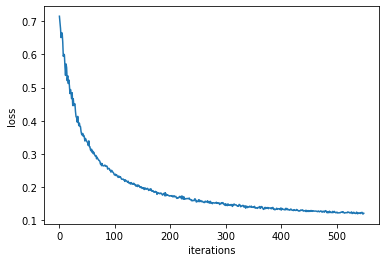

In [20]:
optimizer = optax.adam(learning_rate=0.1)
epochs = 550
seed = jax.random.PRNGKey(10)
params = model.init(seed)

loss_fn = partial(model.loss_fn,batch = Y,  data_size = len(Y), aux = {"X":X}, n_samples = 10)
model_params = train(loss_fn, params, optimizer = optimizer, n_epochs = epochs, seed = jax.random.PRNGKey(10),return_args = ["losses"])

plt.plot(model_params["losses"])
plt.xlabel("iterations")
plt.ylabel("loss")

## Plotting results

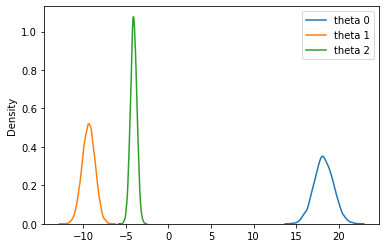

In [21]:
posterior = model.apply(model_params["params"])
samples = posterior.sample(seed = jax.random.PRNGKey(10), sample_shape = (10000,))

sns.kdeplot(samples["theta"][:,0],label = "theta 0")
sns.kdeplot(samples["theta"][:,1], label = "theta 1")
sns.kdeplot(samples["theta"][:,2],label = "theta 2")
plt.legend()

In [23]:
with open("../results/logistic_regression/results_data/logistic_full_rank_Ajax",'wb') as f:
    pickle.dump(posterior, f,protocol = 1)